In [1]:
from call_functions import *
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tikzplotlib

## General Setting

In [2]:
# ------------------------------
# Parameters to tune
# ------------------------------

x0 = 0
L = 2 * np.pi
Nx = 2**6 +1
Nf = Nx // 2
d = 3
dt = 1e-3
a = 1/2 * np.pi
g = 9.80665
gain = 1
T_start = 0
T = 300
N_ini_fq = 2**1

# ------------------------------
# Space discretization
# ------------------------------

dx = L / Nx
Lx = L - dx
xspan = np.arange(x0, Lx + dx, dx)
frequences = np.fft.fftfreq(Nx, dx) * 2 * np.pi
frequences2 = fftfreq(Nx, dx) * 2 * np.pi # same as above

# ------------------------------
# Time discretization
# ------------------------------

T_end = T_start + T
tspan = np.arange(T_start, T_end + dt, dt)
Nt = len(tspan)

In [3]:
frequences

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
       -32., -31., -30., -29., -28., -27., -26., -25., -24., -23., -22.,
       -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
       -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [4]:
# ------------------------------
# Matrix computations
# ------------------------------

# 1) DFT and iDFT Matrices (as well as no mean matrices)
DFT = 1 / Nx * getDFT(Nx)
iDFT = getiDFT(Nx)

# 2) True matrix A not in Fourier
O = np.zeros((Nx, Nx))
I = np.eye(Nx)
G = Matrix_A_dz(Nx, dx, d)
_, C = GetC(np.abs(xspan - np.pi) <= a)
obs_space = np.abs(xspan - np.pi) <= a
C = -np.dot(C.T, C)
A = np.block([[O, -g*I], [G, C]])

# True matrix A in Fourier
fO = np.zeros((2 * Nf + 1, 2 * Nf + 1))
fI = -np.eye(2 * Nf + 1)
fF = np.diag(np.abs(np.concatenate((np.arange(0, Nf + 1), np.arange(-Nf, 0)))))
frequences = fftfreq(Nx, dx) * 2 * np.pi  # Assuming the previously defined fftfreq function
fC = np.real(-((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi))
fA = np.block([[fO, g*fI], [fF, fC]])

# Matrix that deletes the mean
Pi_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nx-1))))

# Matrix that recovers only the mean
Pi_m = np.diag(np.concatenate((np.ones(1),np.zeros(Nx-1))))

# Modified fA
fA_mod_nm = np.block([[fO, g*fI], [fF, Pi_nm @ fC]])

# vector with list of all the positive frequencices
pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# Matrix that deletes the mean and the high frequencies
Pi_lf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# second Modified fA
fA_mod_lf = np.block([[fO, g*fI], [fF, Pi_lf @ fC]])

In [5]:
# ------------------------------
# Print of the projection matrices
# ------------------------------

print('list of frequences :')
print(2 * np.pi * fftfreq(Nx, dx))
print('Pi_nm diagonal :')
print(np.diag(Pi_nm))
print('Pi_lf diagonal :')
print(np.diag(Pi_lf))
print('Pi_hf diagonal :')
print(np.diag(Pi_hf))

list of frequences :
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32. -32. -31. -30. -29. -28. -27. -26. -25. -24.
 -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.
  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
Pi_nm diagonal :
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Pi_lf diagonal :
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Pi_hf diagonal :
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [6]:
# ------------------------------
# Test of the error between Fourier and non Fourier Matrices
# ------------------------------

# Now : DFT @ fF @ iDFT = G

print('relative error between DFT @ fF @ iDFT and G :')
print(np.linalg.norm(np.real(iDFT @ fF @ DFT) - G)/np.linalg.norm(G))

# Now : DFT @ fF @ iDFT = G * np.pi * 2

print('relative error between DFT @ fC @ iDFT and C :')
print(np.linalg.norm(np.real(iDFT @ fC @ DFT) - C)/np.linalg.norm(C))

print('relative error between DFT @ fA @ iDFT and A :')
print(np.linalg.norm(np.real(np.kron(np.eye(2),DFT) @ fA @ np.kron(np.eye(2),iDFT)) - A)/np.linalg.norm(A))

relative error between DFT @ fF @ iDFT and G :
4.6236022669657536e-05
relative error between DFT @ fC @ iDFT and C :
0.13796544907606142
relative error between DFT @ fA @ iDFT and A :
0.004570316283055709


In [7]:
# Comparaison between the C and fC matrices (first row, sinus cardinal vs indicatrice in Fourier space)
px.scatter(x=frequences,y=[np.real(iDFT @ C @ DFT)[0,:],fC[0,:]])

In [8]:
# ------------------------------
# Test for the frequences in a sinus function
# ------------------------------

def f(x):
    return np.sin(x)

print('freqs :',frequences)
print('real DFT :',(np.real(DFT @ f(xspan))) * (abs(np.real(DFT @ f(xspan))) > 1e-10))
print('imag DFT :',(np.imag(DFT @ f(xspan))) * (abs(np.imag(DFT @ f(xspan))) > 1e-10))
print('freqs :',frequences)
print('real ifft :',(np.real(np.fft.fft(f(xspan)))) * (abs(np.real(np.fft.fft(f(xspan)))) > 1e-10))
print('imag ifft :',(np.imag(np.fft.fft(f(xspan)))) * (abs(np.imag(np.fft.fft(f(xspan)))) > 1e-10))

freqs : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32. -32. -31. -30. -29. -28. -27. -26. -25. -24.
 -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.
  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
real DFT : [ 0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0.  0.  0. -0.
  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0.]
imag DFT : [ 0.  -0.5 -0.  -0.   0.   0.   0.  -0.  -0.  -0.  -0.  -0.   0.   0.
  0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.  -0.
  0.  -0.   0.  -0.   0.  -0.   0.   0.   0.   0.   0.  -0.   0.  -0.
 -0.  -0.  -0.   0.  -0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.
 -0.   0.  -0.   0.   0.   0.   0.   0.   0.5]
freqs : [  0.   1.   2.   3.   4.   5.   6.   7

In [9]:
# ------------------------------
# Random initial condition
# ------------------------------

# def create_Fourier_X0(nb_sin, nb_cos, Nx, dx):
#     frequences = fftfreq(Nx, dx) * 2 * np.pi
#     pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]
#     sin_pos = np.random.rand(pos_frequences.shape[0]) * (pos_frequences <= nb_sin)
#     cos_pos = np.random.rand(pos_frequences.shape[0]) * (pos_frequences <= nb_cos)
#     X0 = np.concatenate((np.zeros(1),-sin_pos,sin_pos[::-1]))*1j + np.concatenate((np.zeros(1),cos_pos,cos_pos[::-1]))
#     return X0

# initial condition with N_ini_fq sinus
X0_sin = create_Fourier_X0(N_ini_fq,0, Nx, dx)
# initial condition with N_ini_fq cosinus
X0_cos = create_Fourier_X0(0,N_ini_fq, Nx, dx)
# initial condition with N_ini_fq sinus and N_ini_fq cosinus
X0_mix = create_Fourier_X0(N_ini_fq,N_ini_fq, Nx, dx)

print('number of frequences in initial condition X0_sin :')
print(sum(abs(X0_sin) > 0))
print('number of positive frequences in initial condition X0_sin :')
print(sum((abs(X0_sin) > 0) * (frequences > 0)))
print('number of negative frequences in initial condition X0_sin :')
print(sum((abs(X0_sin) > 0) * (frequences < 0)))

number of frequences in initial condition X0_sin :
4
number of positive frequences in initial condition X0_sin :
2
number of negative frequences in initial condition X0_sin :
2


In [10]:
# plotting the initial condition X0_sin in space

X0_sin_space = iDFT @ (X0_sin)
print('mean of X0 :',np.mean(X0_sin))
px.line(x=xspan,y=[np.real(X0_sin_space),np.imag(X0_sin_space)])

mean of X0 : 0j


In [11]:
# plotting the initial condition X0_mix in space

X0_mix_space = iDFT @ (X0_mix)
print('mean of X0 :',np.mean(X0_mix))
px.line(x=xspan,y=[np.real(X0_mix_space),np.imag(X0_mix_space)])

mean of X0 : (0.01517624406326634+0j)


In [12]:
# Creating fX0_sin, fX0_cos and fX0_mix

fX0_sin = np.concatenate((X0_sin,(1j/g*X0_sin)*np.sqrt(g*np.abs(frequences)*np.tanh(d*np.abs(frequences)))))
fX0_cos = np.concatenate((X0_cos,(1j/g*X0_cos)*np.sqrt(g*np.abs(frequences)*np.tanh(d*np.abs(frequences)))))
fX0_mix = np.concatenate((X0_mix,(1j/g*X0_mix)*np.sqrt(g*np.abs(frequences)*np.tanh(d*np.abs(frequences)))))

In [13]:
# ------------------------------
# Time integration scheme
# ------------------------------

def Euler_Explicit(mat, X0, tspan):
    X = np.zeros((X0.shape[0],tspan.shape[0])) + np.zeros((X0.shape[0],tspan.shape[0]))*1j
    dt = tspan[1] - tspan[0]
    X[:,0] = X0
    for i in range(1,len(tspan)):
        X[:,i] = X[:,i-1] + dt * mat @ X[:,i-1]
    return X

In [14]:
# ------------------------------
# Time integration with fX0_sin
# ------------------------------

fX_sol_EE_fA_sin = Euler_Explicit(fA,fX0_sin,tspan)
print('1st edo : done')
fX_sol_EE_fA_mod_nm_sin = Euler_Explicit(fA_mod_nm,fX0_sin,tspan)
print('2nd edo : done')
fX_sol_EE_fA_mod_lf_sin = Euler_Explicit(fA_mod_lf,fX0_sin,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [15]:
# ------------------------------
# Time integration with fX0_cos
# ------------------------------

fX_sol_EE_fA_cos = Euler_Explicit(fA,fX0_cos,tspan)
print('1st edo : done')
fX_sol_EE_fA_mod_nm_cos = Euler_Explicit(fA_mod_nm,fX0_cos,tspan)
print('2nd edo : done')
fX_sol_EE_fA_mod_lf_cos = Euler_Explicit(fA_mod_lf,fX0_cos,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [16]:
# ------------------------------
# Time integration with fX0_mix
# ------------------------------

fX_sol_EE_fA_mix = Euler_Explicit(fA,fX0_mix,tspan)
print('1st edo : done')
fX_sol_EE_fA_mod_nm_mix = Euler_Explicit(fA_mod_nm,fX0_mix,tspan)
print('2nd edo : done')
fX_sol_EE_fA_mod_lf_mix = Euler_Explicit(fA_mod_lf,fX0_mix,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [34]:
# ------------------------------
# Eigenvalues computations
# ------------------------------

eigval_fA, eigvect_fA = np.linalg.eig(fA)
eigval_fA_mod_nm, eigvect_fA_mod_nm = np.linalg.eig(fA_mod_nm)
eigval_fA_mod_lf, eigvect_fA_mod_lf = np.linalg.eig(fA_mod_lf)

# ------------------------------
# Convergence factor computations
# ------------------------------

conv_fact_fA = np.max(np.real(eigval_fA)[np.real(eigval_fA) < -1e-10])
conv_fact_fA_mod_nm = np.max(np.real(eigval_fA_mod_nm)[np.real(eigval_fA_mod_nm) < -1e-10])
conv_fact_fA_mod_lf = np.max(np.real(eigval_fA_mod_lf)[np.real(eigval_fA_mod_lf) < -1e-10])

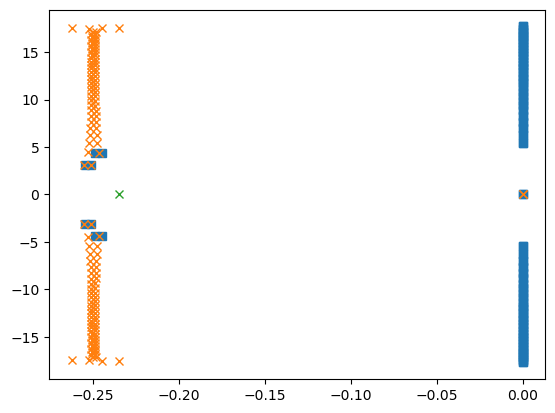

In [52]:
plt.plot(np.real(eigval_fA_mod_lf),np.imag(eigval_fA_mod_lf),'s')
plt.plot(np.real(eigval_fA_mod_nm),np.imag(eigval_fA_mod_nm),'x')
#plt.plot(conv_fact_fA_mod_nm,0,'x')
#plt.plot(conv_fact_fA_mod_lf,0,'x')
plt.plot(conv_fact_fA,0,'x')

### final graphs

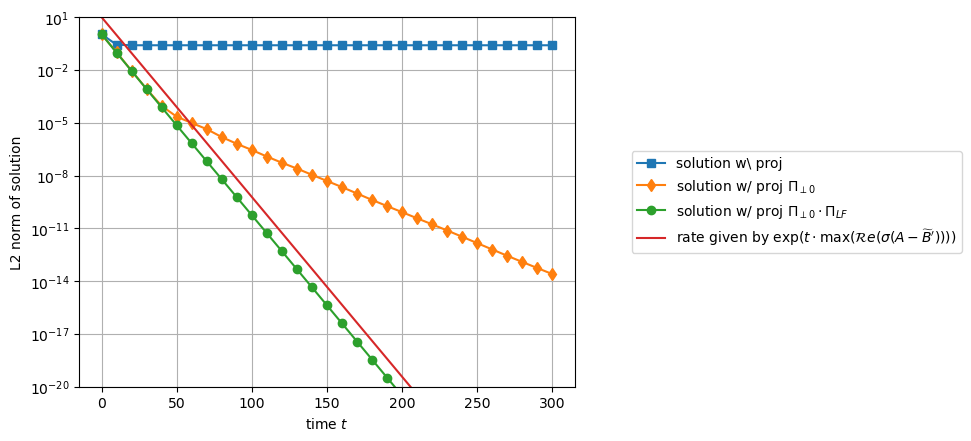

In [73]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
#plt.semilogy(tspan[::steps],np.exp(conv_fact_fA_mod_lf*tspan[::steps]),'-',label=r"theoritical convergence rate")
plt.semilogy(tspan[::steps],10*np.exp(conv_fact_fA*tspan[::steps]),'-',label=r"rate given by $\exp(t\cdot\max(\mathcal{R}e(\sigma(A-\widetilde{B}'))))$")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.xlabel(r'time $t$')
plt.ylabel(r'L2 norm of solution')
plt.savefig("figures_png/lww_obs_conv_ini_sinus&cosinus.png")
tikzplotlib.save("figures_tex/lww_obs_conv_ini_sinus&cosinus.tex")
plt.show()

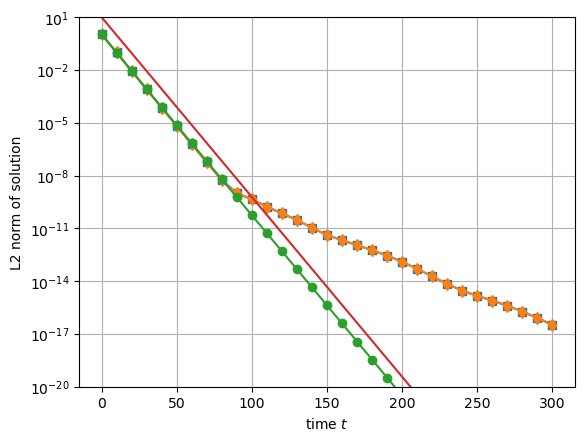

In [74]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.semilogy(tspan[::steps],10*np.exp(conv_fact_fA*tspan[::steps]),'-',label=r"theoritical convergence rate")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
#plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.xlabel(r'time $t$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('figures_png/lww_obs_conv_lf_ini_sinus&cosinus.png')
tikzplotlib.save("figures_tex/lww_obs_conv_lf_ini_sinus&cosinus.tex")
plt.show()

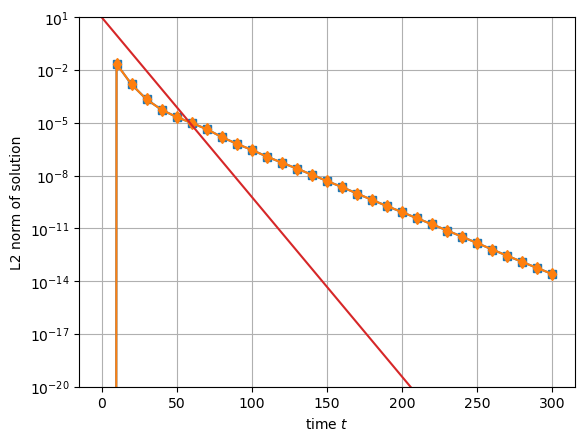

In [75]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.semilogy(tspan[::steps],10*np.exp(conv_fact_fA*tspan[::steps]),'-',label=r"theoritical convergence rate")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
#plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.xlabel(r'time $t$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('figures_png/lww_obs_conv_hf_ini_sinus&cosinus.png')
tikzplotlib.save("figures_tex/lww_obs_conv_hf_ini_sinus&cosinus.tex")
plt.show()

### other graphs 

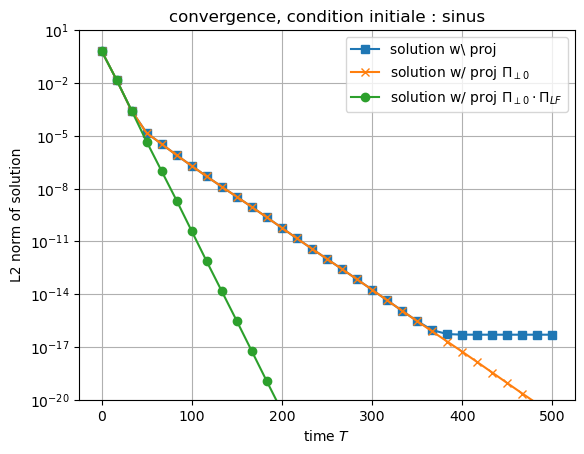

In [ ]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_sin[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_sin[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_sin[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence, condition initiale : sinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('lww_obs_conv_ini_sinus.png')
plt.show()


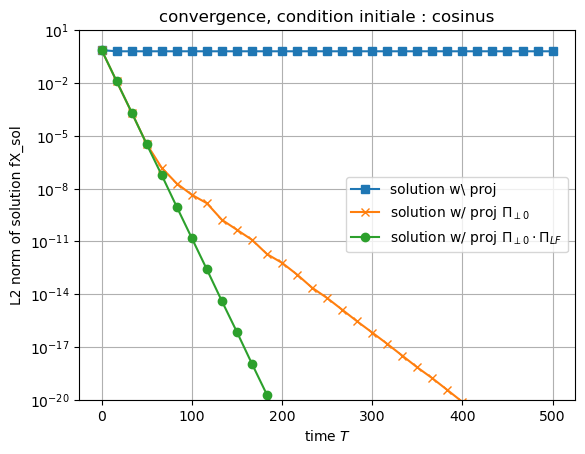

In [ ]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_cos[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution fX_sol')
plt.savefig('lww_obs_conv_ini_cosinus.png')
plt.show()

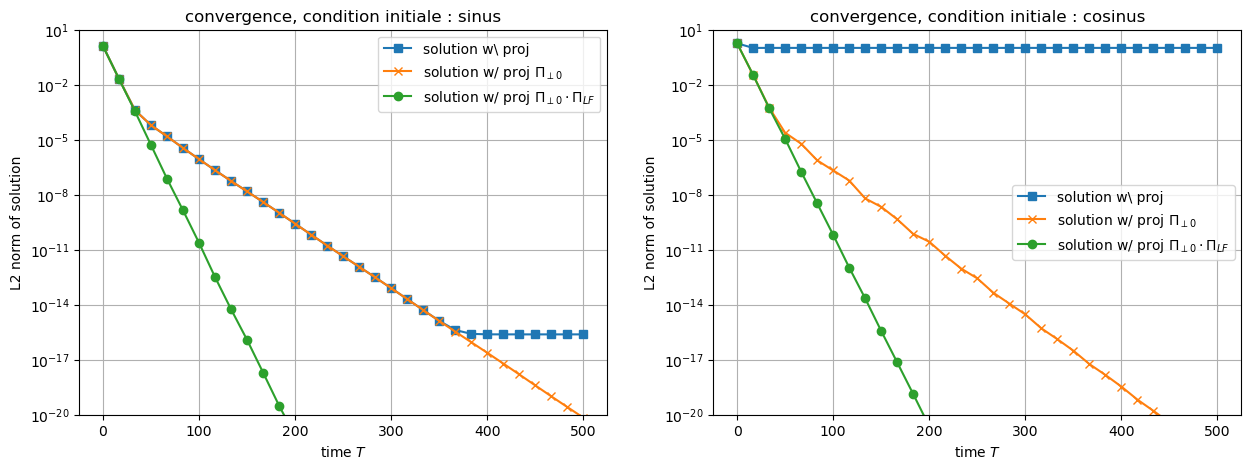

In [ ]:
steps = tspan.shape[0]//30
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_sin[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_sin[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_sin[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence, condition initiale : sinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.subplot(1, 2, 2)
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_cos[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.savefig("lww_obs_conv_ini_sinus_ini_cosinus.png")
tikzplotlib.save("lww_obs_conv_ini_sinus_ini_cosinus.tex")
plt.show()

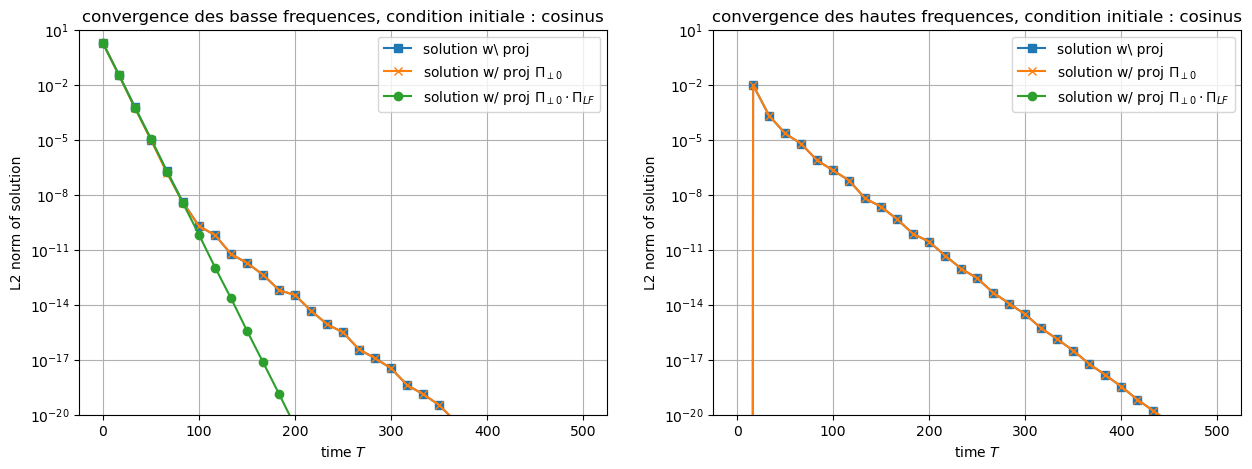

In [20]:
steps = tspan.shape[0]//30
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_lf_cos[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence des basse frequences, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.subplot(1, 2, 2)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_lf_cos[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
plt.title(r'convergence des hautes frequences, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
# plt.subplot(1, 3, 3)
# plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_m) @ fX_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
# plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_m) @ fX_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
# plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_m) @ fX_sol_EE_fA_mod_lf_cos[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
# plt.ylim([1e-3,1e1])
# plt.title(r'convergence mode 0, condition initiale : cosinus + sinus')
# plt.grid()
# plt.legend()
# plt.xlabel(r'time $T$')
# plt.ylabel(r'L2 norm of solution')
plt.savefig('lww_obs_conv_lf_hf_ini_cosinus.png')
tikzplotlib.save("lww_obs_conv_lf_hf_ini_cosinus.tex")
plt.show()

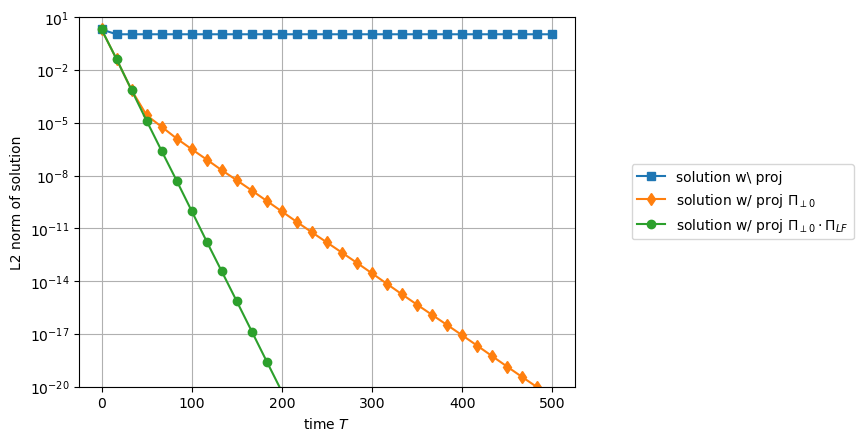

In [41]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('lww_obs_conv_ini_sinus&cosinus.png')
tikzplotlib.save("lww_obs_conv_ini_sinus&cosinus.tex")
plt.show()

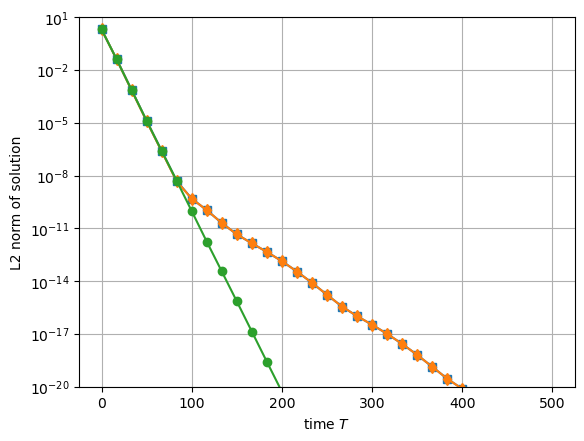

In [39]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
#plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('lww_obs_conv_lf_ini_sinus&cosinus.png')
tikzplotlib.save("lww_obs_conv_lf_ini_sinus&cosinus.tex")
plt.show()

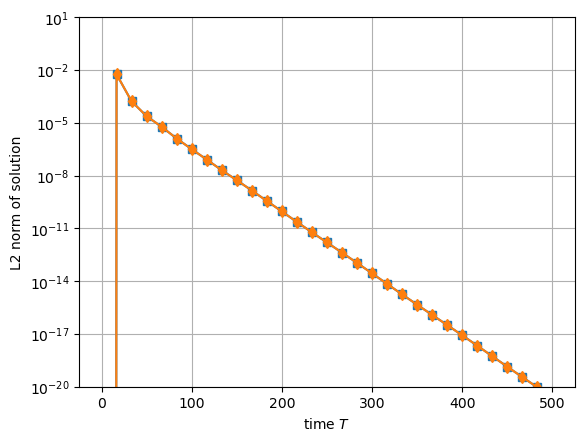

In [40]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-d',label=r"solution w/ proj $\Pi_{\perp 0}$")
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
plt.ylim([1e-20,1e1])
#plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
#plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution')
plt.savefig('lww_obs_conv_hf_ini_sinus&cosinus.png')
tikzplotlib.save("lww_obs_conv_hf_ini_sinus&cosinus.tex")
plt.show()

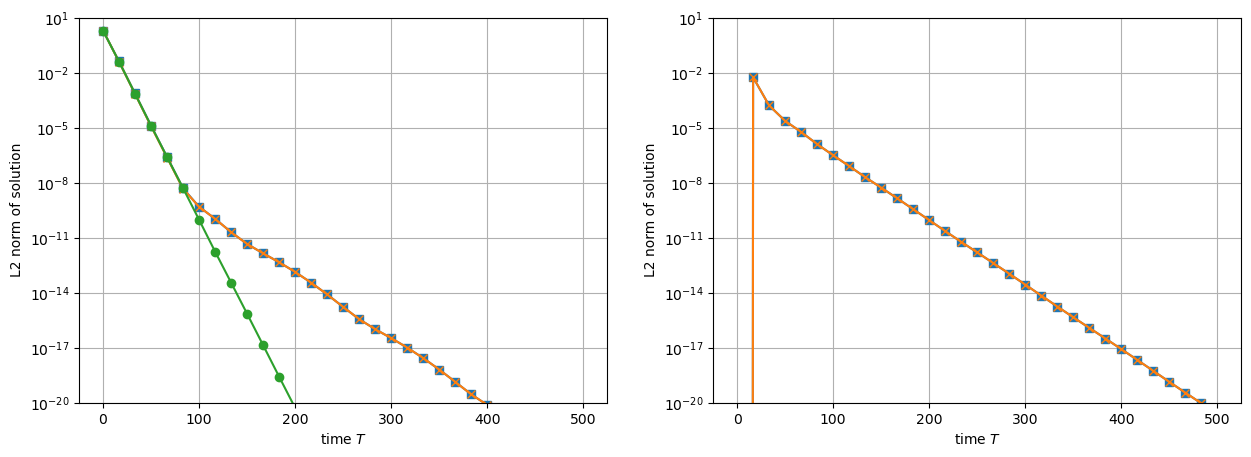

In [30]:
steps = tspan.shape[0]//30

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
ax1.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
ax1.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_lf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
ax1.set_ylim([1e-20,1e1])
#ax1.set_title(r'convergence des basse frequences, condition initiale : cosinus + sinus')
ax1.grid()
#ax1.legend()
ax1.set_xlabel(r'time $T$')
ax1.set_ylabel(r'L2 norm of solution')

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 0
ax2.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label=r"solution w\ proj")
ax2.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label=r"solution w/ proj $\Pi_{\perp 0}$")
ax2.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ fX_sol_EE_fA_mod_lf_mix[0:,::steps],2,axis=0),'-o',label=r"solution w/ proj $\Pi_{\perp 0}\cdot\Pi_{LF}$")
ax2.set_ylim([1e-20,1e1])
#ax2.set_title(r'convergence des hautes frequences, condition initiale : cosinus + sinus')
ax2.grid()
#ax2.legend()
ax2.set_xlabel(r'time $T$')
ax2.set_ylabel(r'L2 norm of solution')

tikzplotlib.save("lww_obs_conv_lf_hf_ini_sinus&cosinus.tex")


## Valeurs propres et convergences

In [70]:
Nff = 2

In [79]:
ffC = -((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi)

In [83]:
np.linalg.norm(np.imag(ffC))

2.145794731967043e-14

In [84]:
fffC = -((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi)

(-1-1.2246467991473532e-16j)

In [119]:
eigenval_fC, _ = np.linalg.eig(fC)
eigenval_Pi_lf_fC, _ = np.linalg.eig(Pi_lf @ fC)
print(np.linalg.norm(np.imag(eigenval_fC)))
print(np.linalg.norm(np.imag(eigenval_Pi_lf_fC)))

3.608756581090733e-16
0.0


In [121]:
np.real(eigenval_fC)

array([5.69775306e-01, 5.44731541e-02, 9.71721323e-01, 2.28138028e-01,
       8.60355808e-01, 1.21803648e-03, 9.09575239e-03, 9.99486417e-01,
       9.95782511e-01, 1.39688712e-05, 1.39309779e-04, 9.99995237e-01,
       9.99946796e-01, 1.24459920e-06, 9.93855968e-08, 9.99999629e-01,
       9.99999975e-01, 1.00000000e+00, 9.99999999e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.15718592e-09,
       4.67033171e-10, 2.77179096e-11, 1.50064872e-12, 7.41991965e-14,
       3.39075154e-15, 4.10203269e-16, 3.32562869e-16, 1.73008590e-16,
       1.14638243e-16, 1.14638243e-16, 1.07194623e-17, 1.00000000e+00,
       1.00000000e+00, 2.58852926e-16, 3.24643844e-16, 2.15018365e-16,
       2.15018365e-16, 2.13325351e-16, 2.13325351e-16, 1.16456442e-16,
       1.16456442e-16, 1.90813187e-16, 1.64691190e-16, 1.64691190e-16,
       1.40799118e-16, 1.40799118e-16, 1.21824513e-16, 1.04902251e-16,
      

In [135]:
np.real(eigenval_Pi_lf_fC)

array([-0.66137059, -0.54891111, -0.00321392, -0.05974393,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

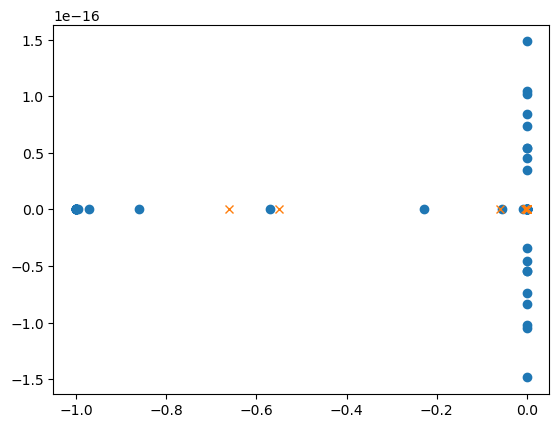

In [124]:
plt.plot(np.real(eigenval_fC),np.imag(eigenval_fC),'o')
plt.plot(np.real(eigenval_Pi_lf_fC),np.imag(eigenval_Pi_lf_fC),'x')

In [141]:
frequences_lf = np.array([0,1,2,-2,-1])
ffC = np.real(-((a * np.exp((-1j * np.pi) * (frequences_lf.reshape(-1, 1) - frequences_lf))) / np.pi) * np.sinc(a * (frequences_lf.reshape(-1, 1) - frequences_lf) / np.pi))
frequences_lf_nm = np.array([1,2,-2,-1])
fffC = np.real(-((a * np.exp((-1j * np.pi) * (frequences_lf_nm.reshape(-1, 1) - frequences_lf_nm))) / np.pi) * np.sinc(a * (frequences_lf_nm.reshape(-1, 1) - frequences_lf_nm) / np.pi))

In [142]:
PiPi_nm = np.diag(np.concatenate((np.zeros(1),np.ones(5-1))))
eigenval_ffC,_ = np.linalg.eig(PiPi_nm @ ffC)
eigenval_fffC,_ = np.linalg.eig(fffC)

In [143]:
eigenval_ffC[0:4] - np.real(eigenval_Pi_lf_fC)[0:4]

array([0., 0., 0., 0.])

In [146]:
np.real(eigenval_Pi_lf_fC)[0:4] - eigenval_fffC

array([ 4.44089210e-16,  2.22044605e-16, -4.72712147e-17, -6.93889390e-18])

In [57]:
np.random.rand(1)

array([0.78817831])